### Style Transfer Exercise

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

### Load VGG

In [2]:
#VGG has two components:
# vgg19.features
# vgg19.classifier
# Only need the features portion, we will load and freeze the weights
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda")
vgg.to(device)

True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [5]:
content = load_image('images/content.jpeg').to(device)
print(content.shape)
style = load_image('images/style.jpg', shape=content.shape[-2:]).to(device)
print(style.shape)

torch.Size([1, 3, 711, 400])
torch.Size([1, 3, 711, 400])


In [6]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

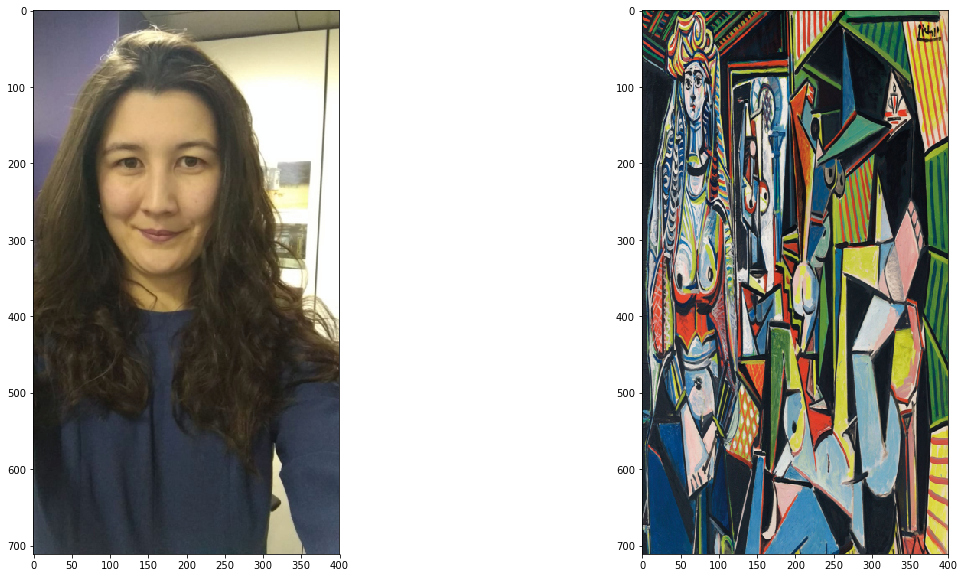

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

### Map out layer names

In [24]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv_1_1',
                 '5':  'conv_2_1',
                 '10': 'conv_3_1',
                 '19': 'conv_4_1',
                 '21': 'conv_4_2',
                 '28': 'conv_5_1',}
        features = {}
        x = image
        for name, layer in model._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

### Gram Matrix

In [25]:
def gram_matrix(tensor):
    _, depth, height, width  = tensor.size()
    tensor = tensor.view(depth, height * width)
    gram = torch.mm(tensor, tensor.t())
    return gram 

In [26]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [27]:
style_weights = {'conv_1_1': 1.,
                 'conv_2_1': 0.75,
                 'conv_3_1': 0.2,
                 'conv_4_1': 0.2,
                 'conv_5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  141257264.0


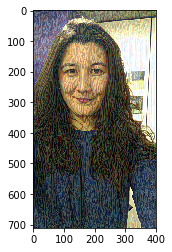

Total loss:  49156952.0


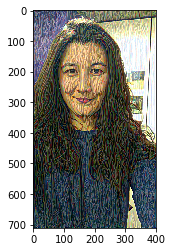

Total loss:  28221500.0


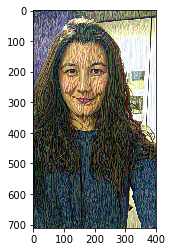

Total loss:  18928486.0


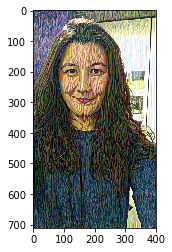

Total loss:  13649564.0


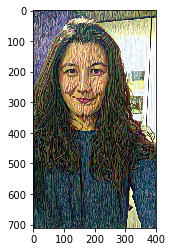

In [28]:
show_every = 400
optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    # get the features from your target image
    target_features = get_features(target, vgg)
    #print(target_features)
    # the content loss
    content_loss = torch.mean((target_features['conv_4_2'] - content_features['conv_4_2'])**2)
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

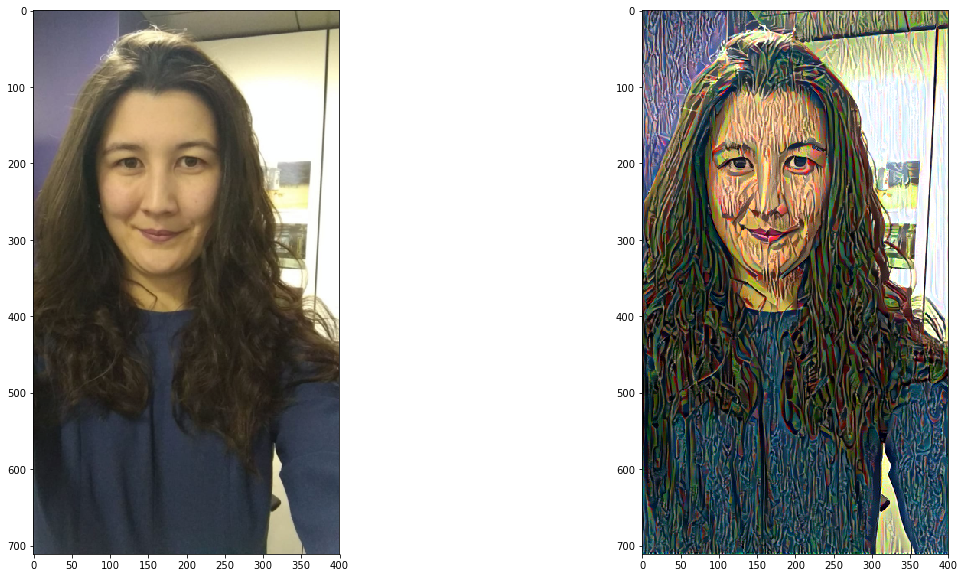

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))